In [1]:
import netCDF4
import xarray as xr
import xesmf as xe
from itertools import cycle
import os
import dask
import numpy as np
import pandas as pd
import dask.array as da
import dask.bag as db
from pykdtree.kdtree import KDTree
from dask.diagnostics import ProgressBar
import subprocess
import matplotlib.pyplot as plt

os.chdir("/home/149/ab8992/cosima_regional/mom6-regional-scripts")
print(os.getcwd())

# Import scripts
from regional_model_scripts import input_datasets, interp_segment,prepare_segments, time_rotate,regrid_runoff,sel_hgrid_indices
from boundary_tides import write_tpxo

om2path = "/g/data/ik11/inputs/access-om2/input_08022019/mom_01deg/" ## Access om2_01 input for topography and hgrid
initpath = "/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output1077" ## Access om2_01 output for BCs and IC
toolpath = "/g/data/v45/jr5971/FRE-NCtools/build3_up_MAXXGRID/tools/" ## Compiled tools needed for construction of mask tables
    
xr.set_options(keep_attrs=True) ## This ensures that performing simple operations with xarray (eg converting temperature to Celsius) preserves attributes

from dask.distributed import Client
client = Client()
client

/home/149/ab8992/cosima_regional/mom6-regional-scripts


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33907 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33907/status,
Dashboard: /proxy/33907/status,Workers: 4
Total threads: 4,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35291,Workers: 4
Dashboard: /proxy/33907/status,Total threads: 4
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:45007,Total threads: 1
Dashboard: /proxy/33561/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:35491,


# *30th degree topography version*

This notebook takes the 10th degree hgrid and generates a 30th degree one. It then copies the Gebco topography and interpolates it onto this grid (using John Reilly's script). With a *new* hgrid and topog.nc , this notebook then follows the same steps as before.

## Current issues 
* On the test domain around Tassie there are obvious anomalies in pretty much all fields near the boundary. They are present after 5 days - currently running longer to see if they go away with time.
* For larger domains, the 'interp segments' struggles to run in the notebook. Better to run as a pbs script - these files are pushed to the repository too but not incorporated into this notebook

# *Text from original notebook below*

# What this notebook does:

Given a choice of lat / lon coordinates, a hgrid is built from an existing access om2_01 global run. Then, all of the other required input files are interpolated onto this hgrid, and Angus Gibson's 'Brushcutter' creates files for boundary files. It also sets up the mask tables and regrids the runoff, sorting out everything you need to run the experiment.

An input directory is copied into the 'rundir' you choose, and a couple of files are automatically modified based on your experiment. As longs as you don't change your default layout, you

# What's still to do:

* Test whether this setup works for a pan-antarctic style domain. In that case you'd need to set REENTRANT_X = True in MOM_input. Otherwise there might be some other things that need changing to ensure that the input files wrap around properly

* Handle the case where you want to look at a domain that straddles the 'seam' in longitude coordinate at -180.

# Troubleshooting:
* You can get some really weird errors if there are little bays trapped on your boundaries. Try to either avoid this, or fill them in manually if they appear. This is what I was getting: 

"FATAL from PE    56: MOM_regridding: adjust_interface_motion() - implied h<0 is larger than roundoff!"

* If you alter the remapping code, be sure to check that your netcdf files have sensible attributes. You can check yours against a working model by ensuring your attributes match with /scratch/v45/ab8992/mom6/regional_configs/ttide-new/

## Choose your Domain, and set path to your input and run directories

Text(0.5, 1.0, 'mom6_003_round2 domain')

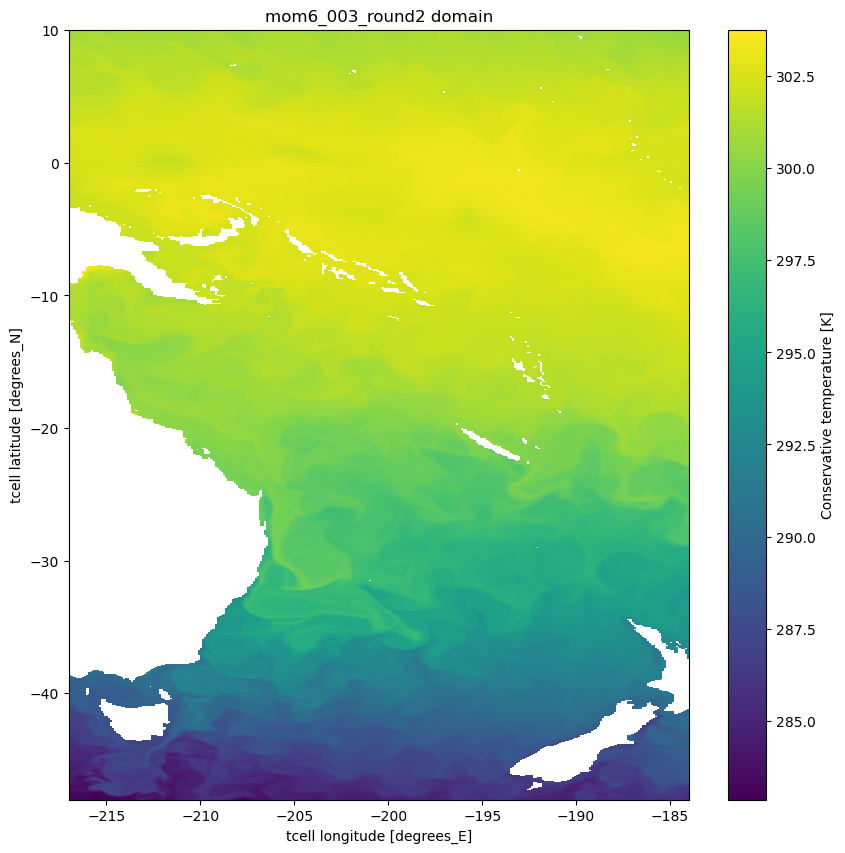

In [2]:

## Choose your coordinates and the name of your experiment
yextent = [-48, 10]
xextent = [-217 , -184]
expt_name = "mom6_003_round2"

## Place where all your input files go
path = f"/scratch/v45/jr5971/mom6/regional_configs/{expt_name}/"

## Directory where you'll run the experiment from
rundir = f"/home/581/jr5971/mom6_rundirs/{expt_name}"

for i in [path,rundir]:
    try:
        os.mkdir(i)
    except:
        pass

if "temp" not in os.listdir(path):
    os.mkdir(path + "temp")
if "weights" not in os.listdir(path):
    os.mkdir(path + "weights")
if "forcing" not in os.listdir(path):
    os.mkdir(path + "forcing")


full_domain = xr.open_dataset(f"{initpath}/ocean/ocean_daily.nc")

# domain.tau_x.sel(yu_ocean=slice(-49, -5), xu_ocean=slice(-217, -183)).isel(time = 0).plot()
domain = full_domain.surface_temp.sel(yt_ocean=slice(yextent[0], yextent[1]), xt_ocean=slice(xextent[0],xextent[1])).isel(time = 0)
fig,ax = plt.subplots(1,figsize = (10,10))

domain.plot(ax = ax)
ax.set_title(f"{expt_name} domain")

## *********************Addition**********************
Here, I'm just looking to explore the creation of the vertical coordinate. There are various options for the spacing and rate of change in the spacing, so I just want to understand what `make_vgrid` can do and whether there are any other tools that might do something similar. 
`
make_vgrid --nbnds nbnds --bnds z(1),...,z(nbnds) [--nz nz(1),...,nz(nbnds-1)]
            [--dbnds dbnds(1),...,dbnds(nbnds)] [--stretch stretch]
            [--grid_name gridname] [--center center]
`
*make_vgrid* is used to make a vertical grid for an FMS model. It uses a piecewise monotonic shape preserving cubic-spline algorithm to calculate the grid cell location. The output netcdf file contains information on the supergrid with grid size equlal to the model grid size multiplied by a refinement factor of two. 
* --nz needs to be specified to use the monotonic cubic algorithm. Since monotonic cubic interpolation is a higher order interpolation, it will produce smoother grid distance. It is strongly suggested to use the monotonic cubic interpolation by specifying argument --nz.


# Step by step procedure to set up experiment

# 1. Find the indices of the hgrid that we need based on the lat/lon chosen above

topog_gen notebook can generate the higher resolution topography

In [3]:
hgrid = xr.open_dataset(om2path + "ocean_hgrid.nc")

x_indices_hgrid = sel_hgrid_indices(hgrid.x.isel(nyp = 1000,nxp = slice(0,None,2)),xextent)  ## As long as it's away from the north pole things are ok since lon doesn't vary with lat
y_indices_hgrid = sel_hgrid_indices(hgrid.y.isel(nxp = 0,nyp = slice(0,None,2)),yextent) 

encoding = {'x': {'_FillValue': None},
            'y': {'_FillValue': None},
            "dx": {"_FillValue": None},
            'dy': {'_FillValue': None},
            'angle_dx': {'_FillValue': None},
            'area': {'_FillValue': None}
            }  

hgrid_new = hgrid.isel(
    nyp = slice(y_indices_hgrid[0] , y_indices_hgrid[1] ),
    nxp = slice(x_indices_hgrid[0] , x_indices_hgrid[1] ),
    ny = slice(y_indices_hgrid[0] , y_indices_hgrid[1] - 1 ),
    nx = slice(x_indices_hgrid[0] , x_indices_hgrid[1] - 1 ))



## 1.1 Increase resolution of domain hgrid
Here, we take the original coordinate values in the x & y directions, divide the spaces between each consecutive pair by three, and add 2 more equally spaced values in between each original pair to get 3 times the original resolution. 
- We then create a meshgrid with these new values for both corner and tracer points and make a new dataset that has these new arrays representing the new lat and lon values

**NOTE**: All the printing was just a sanity check and can be removed eventually

In [6]:
x = hgrid_new.x.isel(nyp=0).values # get x-coordinate values
# print(f"first five points of x on original supergrid are :{x[:5]}, \n and space between points is {round(x[1]-x[0],2)}")
xc = x[::2] # Select every second x-value, i.e the "corner points" of a staggered grid
xc3_delta = (xc[1:] - xc[:-1]) / 3 # Divide the space between each pair of points by three. 
xc3 = np.concatenate([xc, xc[:-1]+xc3_delta, xc[:-1]+2*xc3_delta]) # add in the extra variables. 
xc3 = np.sort(xc3)
# print(f"\n first five new corner points of hgrid are: {xc3[:5]}, \n and space between points is {xc3[1]-xc3[0]}")
xt3 = (xc3[1:] + xc3[:-1])/2
# print(f"\n first five new tracer points of hgrid are: {xt3[:5]}, \n and space between tracer points is {xt3[1]-xt3[0]}")
y = hgrid_new.y.isel(nxp=0).values
yc = y[::2]
yc3_delta = (yc[1:] - yc[:-1]) / 3
yc3 = np.sort(np.concatenate([yc, yc[:-1]+yc3_delta, yc[:-1]+2*yc3_delta]))
# print(f"\n first five new corner points of hgrid are: {yc3[-5:]}, \n and space between points is {yc3[-1]-yc3[-2]}")
yt3 = (yc3[1:] + yc3[:-1])/2
# print(f"\n first five new tracer points of hgrid are: {yt3[:5]}, \n and space between tracer points is {yt3[1]-yt3[0]}")
# print(f"\n difference between the corner and tracer points in x are: {xt3[0]-xc3[0]} degrees longitude")

# broadcast to meshgrid
XC, YC = np.meshgrid(xc3, yc3)
XT, YT = np.meshgrid(xt3, yt3)

# create output dataset
ds = xr.Dataset({
    "grid_lon": (['grid_yc', 'grid_xc'], XC),
    'grid_lat': (['grid_yc', 'grid_xc'], YC),
    'grid_lont': (['grid_yt', 'grid_xt'], XT),
    'grid_latt': (['grid_yt', 'grid_xt'], YT),
})

ds.to_netcdf(path + 'grid_30th-deg.nc')

## Generate the hgrid from this higher res meshgrid
args = "--grid_type from_file --my_grid_file grid_30th-deg.nc".split(" ")
print("MAKE HGRID", subprocess.run([toolpath + "make_hgrid/make_hgrid"] + args, cwd=path), sep="\n")
subprocess.run(["mv","horizontal_grid.nc","hgrid.nc"],cwd=path)

[INFO] tile: 0, nxl[1980], nyl[3888], ntiles: 1


MAKE HGRID
CompletedProcess(args=['/g/data/v45/jr5971/FRE-NCtools/build3_up_MAXXGRID/tools/make_hgrid/make_hgrid', '--grid_type', 'from_file', '--my_grid_file', 'grid_30th-deg.nc'], returncode=0)


CompletedProcess(args=['mv', 'horizontal_grid.nc', 'hgrid.nc'], returncode=0)

In [3]:
hgrid = xr.open_dataset(path+'hgrid.nc')
hgrid

<xarray.Dataset>
Dimensions:   (nyp: 3889, nxp: 1981, nx: 1980, ny: 3888)
Dimensions without coordinates: nyp, nxp, nx, ny
Data variables:
    tile      |S255 ...
    x         (nyp, nxp) float64 ...
    y         (nyp, nxp) float64 ...
    dx        (nyp, nx) float64 ...
    dy        (ny, nxp) float64 ...
    area      (ny, nx) float64 ...
    angle_dx  (nyp, nxp) float64 ...
    arcx      |S255 ...
Attributes:
    grid_version:          0.2
    code_release_version:  2022.02
    git_hash:              83acb799f47dfa27b433a131e9f7c1310767cc59
    creationtime:          Tue Mar  7 14:34:25 2023
    hostname:              gadi-cpu-bdw-0019.gadi.nci.org.au
    history:               /g/data/v45/jr5971/FRE-NCtools/build3_up_MAXXGRID/...

# 2 Load in GEBCO 2022 topography dataset, cut down to region of interest and use FRE-tools to interpolate data onto higher resolution hgrid

In [7]:
gebco_path = '/g/data/ik11/inputs/GEBCO_2022/GEBCO_2022.nc'
gebco_ds = xr.open_dataset(gebco_path)
geb_idx = {'W':xextent[0]+360, 'E':xextent[1]+360,
           'S':yextent[0], 'N':yextent[1]}
geb_eac = gebco_ds.sel(lon=slice(geb_idx['W'], geb_idx['E']),
                       lat=slice(geb_idx['S'], geb_idx['N']))['elevation'].astype("float")


geb_eac.attrs['missing_value'] = -1e20
geb_eac.to_netcdf(path+'gebco_eac.nc')

## 2.1 Generate `ocean_mosaic.nc` from the hgrid, then make the topography from the mosaic and the cut-out gebco data

In [ ]:
args = "--num_tiles 1 --dir . --mosaic_name ocean_mosaic --tile_file hgrid.nc".split(" ")

print("MAKE SOLO MOSAIC",subprocess.run([toolpath + "make_solo_mosaic/make_solo_mosaic"] + args, cwd=path), sep="\n")

args = "--mosaic ocean_mosaic.nc --topog_type realistic --topog_file gebco_eac.nc --topog_field elevation --scale_factor -1 --output topog.nc".split(" ")

print(
    subprocess.run(["/g/data/v45/jr5971/FRE-NCtools/build3_up_MAXXGRID/tools/make_topog/make_topog_parallel"] + args,cwd = path)
)

## 2.2 Run `deseas` script to remove lakes, little bays and straights from the topography that would mess up ocean mask

In [4]:
path

'/scratch/v45/jr5971/mom6/regional_configs/mom6_003_round2/'

In [15]:
args = f"topog.nc deseas_topog.nc".split(" ")

subprocess.run(["/home/149/ab8992/tools/topogtools/deseas"] + args,cwd = path)

     1423813         971
        1711          18
          21           3
           0           1
 Wring
 FATAL ERROR:
 Permission denied                                                              
  


CompletedProcess(args=['/home/149/ab8992/tools/topogtools/deseas', 'topog.nc', 'deseas_topog.nc'], returncode=0)

In [17]:

# args = f"topog.nc deseas_topog.nc".split(" ")

# subprocess.run(["/home/149/ab8992/tools/topogtools/deseas"] + args,cwd = path)


## Now just fiddle with the metadata to make sure that the array returned
## by 'deseas' will work with mom6 
#  
topog = xr.open_dataset(path + "topog.nc")
deseas = xr.open_dataset(path + "deseas_topog.nc")
topog.depth[:,:] = deseas.depth.values
# topog.expand_dims({'ntiles':1}).to_netcdf(path + "new_topog.nc",mode = "w",encoding={"depth":{'_FillValue': None}} )
topog.to_netcdf(path + "new_topog.nc",mode = "w",encoding={"depth":{'_FillValue': None}} )

subprocess.run(["mv","new_topog.nc","topog.nc"],cwd=path)

CompletedProcess(args=['mv', 'new_topog.nc', 'topog.nc'], returncode=0)

In [23]:
topog

<xarray.Dataset>
Dimensions:  (ntiles: 1, ny: 1944, nx: 990)
Dimensions without coordinates: ntiles, ny, nx
Data variables:
    depth    (ntiles, ny, nx) float64 ...
Attributes:
    grid_version:          0.2
    code_release_version:  2022.02
    git_hash:              83acb799f47dfa27b433a131e9f7c1310767cc59
    creationtime:          Thu Feb 23 05:57:18 2023
    hostname:              gadi-cpu-clx-0121.gadi.nci.org.au
    history:               /g/data/v45/jr5971/FRE-NCtools/build3_up_MAXXGRID/...

# 3. Cut out the initial condition velocities and interpolate onto the cgrid

Here we can use the normal xarray select tool to get the initial velocities. This is set by default to be at time=30, as this is how Angus set things up. 

The horizontal coordinates are a bit of a mess. Initially, the mom5 data uses xu_ocean,xt_ocean etc. In MOM6, yh,xq etc are used. Here, they're renamed to "lat/lon" for the regridder. Afterwards, the velocities are named in the "xh,yq" convention, but the tracers aren't. This is to be consistent with Angus' example EAC configuration. I suspect there would be no issue renaming the coordinates consistently if the relevent MOM files were altered to match. 

Note also that the "encoding" parameters are needed to overwrite xarray's default values. xr will put in its own NaNs as the _FillVallue which aren't compatible with MOM6

In [6]:
## Make a 'buffer' 1 degree East, West, North and South of your domain. This is to ensure that the regridder is able to interpolate properly without giving 
## zeroes at the boundaries of the domain. For the default resolution this was fine given grid stayed the same, but breaks for high res
xbuffer = [xextent[0] - 1 , xextent[-1] + 1]
ybuffer = [yextent[0] - 1 , yextent[-1] + 1]

# xbuffer = [xextent[0] , xextent[-1]]
# ybuffer = [yextent[0] , yextent[-1]]


## pull out the initial velocity on MOM5's Bgrid


u_init_bgrid = xr.open_dataset(f"{initpath}/ocean/ocean_daily_3d_u.nc").u.rename({"xu_ocean": "lon", "yu_ocean": "lat"}).sel(
    lon = slice(xbuffer[0],xbuffer[1]),lat = slice(ybuffer[0],ybuffer[1])).isel(time = 30)
v_init_bgrid = xr.open_dataset(f"{initpath}/ocean/ocean_daily_3d_v.nc").v.rename({"xu_ocean": "lon", "yu_ocean": "lat"}).sel(
    lon = slice(xbuffer[0],xbuffer[1]),lat = slice(ybuffer[0],ybuffer[1])).isel(time = 30)

## Pull out the surface height, temp and salinity initial conds
temperature = xr.open_dataset(f"{initpath}/ocean/ocean_daily_3d_temp.nc").temp.isel(time = 30).sel(
    yt_ocean = slice(ybuffer[0],ybuffer[1]),xt_ocean = slice(xbuffer[0],xbuffer[1]))  - 273.15## Convert to Celcius for MOM6!
salt = xr.open_dataset(f"{initpath}/ocean/ocean_daily_3d_salt.nc").salt.isel(time = 30).sel(
    yt_ocean = slice(ybuffer[0],ybuffer[1]),xt_ocean = slice(xbuffer[0],xbuffer[1]))

## Merge tracer ICs together
init_cond = xr.merge([temperature,salt]).drop_vars("time").rename({"xt_ocean": "lon", "yt_ocean": "lat"})

init_eta = xr.open_dataset(f"{initpath}/ocean/ocean_daily.nc").isel(time = 30).sel(
    yt_ocean = slice(ybuffer[0],ybuffer[1]),xt_ocean = slice(xbuffer[0],xbuffer[1])).rename({"xt_ocean": "lon", "yt_ocean": "lat"})


## Construct the xq,yh and xh yq grids
ugrid = hgrid[["x","y"]].isel(nxp=slice(None, None, 2), nyp=slice(1, None, 2)).rename({"x": "lon", "y": "lat"}).set_coords(["lat","lon"])
vgrid = hgrid[["x","y"]].isel(nxp=slice(1, None, 2), nyp=slice(None, None, 2)).rename({"x": "lon", "y": "lat"}).set_coords(["lat","lon"])



## Construct the cell centre grid for tracers (xh,yh). 
tgrid = xr.Dataset(
    {"lon":(["lon"],hgrid.x.isel(nxp=slice(1, None, 2), nyp=1).values),
     "lat":(["lat"],hgrid.y.isel(nxp=1, nyp=slice(1, None, 2)).values)
            }
)



### Drop NaNs to be re-added later
# NaNs are from the land mask. When we interpolate onto a new grid, need to put in the new land mask. If NaNs left in, land mask stays the same

u_init_bgrid = u_init_bgrid.interpolate_na("lon",method = "nearest").ffill("lon").bfill("lon")
v_init_bgrid = v_init_bgrid.interpolate_na("lon",method = "nearest").ffill("lon").bfill("lon")
init_cond = init_cond.interpolate_na("lon",method = "nearest").ffill("lon").bfill("lon")

regridder_u = xe.Regridder(
    u_init_bgrid, ugrid, "bilinear",
)
regridder_v = xe.Regridder(
    v_init_bgrid, vgrid, "bilinear",
)

regridder_t = xe.Regridder(
    init_cond, tgrid, "bilinear",
)

u_on_c = regridder_u(u_init_bgrid)

# u_on_c = u_on_c.rename({"nyp": "ny"})
u_on_c = u_on_c.rename({"lon": "xq", "lat": "yh", "nyp": "ny"})

u_on_c.name = "u"
## Give attributes back
u_on_c.attrs = u_init_bgrid.attrs 
u_on_c.xq.attrs = u_init_bgrid.lon.attrs
u_on_c.yh.attrs = u_init_bgrid.lat.attrs
u_on_c.st_ocean.attrs = u_init_bgrid.st_ocean.attrs

v_on_c = regridder_v(v_init_bgrid)
v_on_c = v_on_c.rename({"lon": "xh", "lat": "yq", "nxp": "nx"})
# v_on_c = v_on_c.rename({"nxp": "nx"})

v_on_c.name = "v"
## Give attributes back
v_on_c.attrs = v_init_bgrid.attrs 
v_on_c.xh.attrs = v_init_bgrid.lon.attrs
v_on_c.yq.attrs = v_init_bgrid.lat.attrs
v_on_c.st_ocean.attrs = v_init_bgrid.st_ocean.attrs

vel_init_cgrid = xr.merge((u_on_c, v_on_c),)
vel_init_cgrid.st_ocean.attrs["axis"] = "Z"

vel_init_cgrid.fillna(0).drop_vars("time").to_netcdf(
    path + "forcing/init_vel_cgrid.nc",
    mode = "w",
    encoding={
        "u": {"_FillValue": netCDF4.default_fillvals["f4"]},
        "v": {"_FillValue": netCDF4.default_fillvals["f4"]}        
    },
)


## regrid tracers
init_cond_rg = regridder_t(init_cond)
init_cond_rg = init_cond_rg.rename({"lon": "xt_ocean", "lat": "yt_ocean"})
## Give attributes back
init_cond_rg.attrs = init_cond.attrs 
init_cond_rg.xt_ocean.attrs = init_cond.lon.attrs
init_cond_rg.yt_ocean.attrs = init_cond.lat.attrs
init_cond_rg.st_ocean.attrs = init_cond.st_ocean.attrs

init_cond_rg.to_netcdf(
    path + "forcing/init_cond.nc",
    mode = "w",
    encoding = {'xt_ocean': {'_FillValue': None},
                'yt_ocean': {'_FillValue': None},
                "st_ocean": {"_FillValue": None},
                'temp': {'_FillValue': -1e20,'missing_value': -1e20},
                'salt': {'_FillValue': -1e20,'missing_value': -1e20}
                },
)


## regrid eta
init_eta_rg = regridder_t(init_eta.eta_t.interpolate_na("lon",method = "nearest").ffill("lon").bfill("lon"))
init_eta_rg = init_eta_rg.rename({"lon": "xt_ocean", "lat": "yt_ocean"})

## Give attributes back
init_eta_rg.attrs = init_eta.attrs 
init_eta_rg.xt_ocean.attrs = init_eta.lon.attrs
init_eta_rg.yt_ocean.attrs = init_eta.lat.attrs


init_eta_rg.name = "eta_t"

init_eta_rg.drop_vars("time").to_netcdf(
    path + "forcing/init_eta.nc",
    mode = "w",
    encoding = {'xt_ocean': {'_FillValue': None},
                'yt_ocean': {'_FillValue': None},
                'eta_t':{'_FillValue':None}
                },
)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/conventions.py:827: SerializationWarning: cannot serialize global coordinates {'yh', 'yq', 'xh', 'xq'} because the global attribute 'coordinates' already exists. This may prevent faithful roundtrippingof xarray datasets
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect perfor

In [28]:
## pull out the initial velocity on MOM5's Bgrid
u_init_bgrid = xr.open_dataset(f"{initpath}/ocean/ocean_daily_3d_u.nc").u.rename({"xu_ocean": "lon", "yu_ocean": "lat"}).sel(
    lon = slice(xextent[0],xextent[1]),lat = slice(yextent[0],yextent[1])).isel(time = 30)
v_init_bgrid = xr.open_dataset(f"{initpath}/ocean/ocean_daily_3d_v.nc").v.rename({"xu_ocean": "lon", "yu_ocean": "lat"}).sel(
    lon = slice(xextent[0],xextent[1]),lat = slice(yextent[0],yextent[1])).isel(time = 30)

## Pull out the surface height, temp and salinity initial conds
temperature = xr.open_dataset(f"{initpath}/ocean/ocean_daily_3d_temp.nc").temp.isel(time = 30).sel(
    yt_ocean = slice(yextent[0],yextent[1]),xt_ocean = slice(xextent[0],xextent[1]))  - 273.15## Convert to Celcius for MOM6!
salt = xr.open_dataset(f"{initpath}/ocean/ocean_daily_3d_salt.nc").salt.isel(time = 30).sel(
    yt_ocean = slice(yextent[0],yextent[1]),xt_ocean = slice(xextent[0],xextent[1]))

## Merge tracer ICs together
init_cond = xr.merge([temperature,salt]).drop_vars("time").rename({"xt_ocean": "lon", "yt_ocean": "lat"})

init_eta = xr.open_dataset(f"{initpath}/ocean/ocean_daily.nc").isel(time = 30).sel(
    yt_ocean = slice(yextent[0],yextent[1]),xt_ocean = slice(xextent[0],xextent[1])).rename({"xt_ocean": "lon", "yt_ocean": "lat"})


## Construct the xq,yh and xh yq grids
ugrid = hgrid[["x","y"]].isel(nxp=slice(None, None, 2), nyp=slice(1, None, 2)).rename({"x": "lon", "y": "lat"}).set_coords(["lat","lon"])
vgrid = hgrid[["x","y"]].isel(nxp=slice(1, None, 2), nyp=slice(None, None, 2)).rename({"x": "lon", "y": "lat"}).set_coords(["lat","lon"])



## Construct the cell centre grid for tracers (xh,yh). 
tgrid = xr.Dataset(
    {"lon":(["lon"],hgrid.x.isel(nxp=slice(1, None, 2), nyp=1).values),
     "lat":(["lat"],hgrid.y.isel(nxp=1, nyp=slice(1, None, 2)).values)
            }
)



### Drop NaNs to be re-added later
# NaNs are from the land mask. When we interpolate onto a new grid, need to put in the new land mask. If NaNs left in, land mask stays the same

u_init_bgrid = u_init_bgrid.interpolate_na("lon",method = "nearest").ffill("lon").bfill("lon")
v_init_bgrid = v_init_bgrid.interpolate_na("lon",method = "nearest").ffill("lon").bfill("lon")
init_cond = init_cond.interpolate_na("lon",method = "nearest").ffill("lon").bfill("lon")

regridder_u = xe.Regridder(
    u_init_bgrid, ugrid, "bilinear",
)
regridder_v = xe.Regridder(
    v_init_bgrid, vgrid, "bilinear",
)

regridder_t = xe.Regridder(
    init_cond, tgrid, "bilinear",
)

u_on_c = regridder_u(u_init_bgrid)

# u_on_c = u_on_c.rename({"nyp": "ny"})
u_on_c = u_on_c.rename({"lon": "xq", "lat": "yh", "nyp": "ny"})

u_on_c.name = "u"
## Give attributes back
u_on_c.attrs = u_init_bgrid.attrs 
u_on_c.xq.attrs = u_init_bgrid.lon.attrs
u_on_c.yh.attrs = u_init_bgrid.lat.attrs
u_on_c.st_ocean.attrs = u_init_bgrid.st_ocean.attrs

v_on_c = regridder_v(v_init_bgrid)
v_on_c = v_on_c.rename({"lon": "xh", "lat": "yq", "nxp": "nx"})
# v_on_c = v_on_c.rename({"nxp": "nx"})

v_on_c.name = "v"
## Give attributes back
v_on_c.attrs = v_init_bgrid.attrs 
v_on_c.xh.attrs = v_init_bgrid.lon.attrs
v_on_c.yq.attrs = v_init_bgrid.lat.attrs
v_on_c.st_ocean.attrs = v_init_bgrid.st_ocean.attrs

vel_init_cgrid = xr.merge((u_on_c, v_on_c),)
vel_init_cgrid.st_ocean.attrs["axis"] = "Z"

vel_init_cgrid.fillna(0).drop_vars("time").to_netcdf(
    path + "forcing/init_vel_cgrid.nc",
    mode = "w",
    encoding={
        "u": {"_FillValue": netCDF4.default_fillvals["f4"]},
        "v": {"_FillValue": netCDF4.default_fillvals["f4"]}        
    },
)


## regrid tracers
init_cond_rg = regridder_t(init_cond)
init_cond_rg = init_cond_rg.rename({"lon": "xt_ocean", "lat": "yt_ocean"})
## Give attributes back
init_cond_rg.attrs = init_cond.attrs 
init_cond_rg.xt_ocean.attrs = init_cond.lon.attrs
init_cond_rg.yt_ocean.attrs = init_cond.lat.attrs
init_cond_rg.st_ocean.attrs = init_cond.st_ocean.attrs

init_cond_rg.to_netcdf(
    path + "forcing/init_cond.nc",
    mode = "w",
    encoding = {'xt_ocean': {'_FillValue': None},
                'yt_ocean': {'_FillValue': None},
                "st_ocean": {"_FillValue": None},
                'temp': {'_FillValue': -1e20,'missing_value': -1e20},
                'salt': {'_FillValue': -1e20,'missing_value': -1e20}
                },
)


## regrid eta
init_eta_rg = regridder_t(init_eta.eta_t.interpolate_na("lon",method = "nearest").ffill("lon").bfill("lon"))
init_eta_rg = init_eta_rg.rename({"lon": "xt_ocean", "lat": "yt_ocean"})

## Give attributes back
init_eta_rg.attrs = init_eta.attrs 
init_eta_rg.xt_ocean.attrs = init_eta.lon.attrs
init_eta_rg.yt_ocean.attrs = init_eta.lat.attrs


init_eta_rg.name = "eta_t"

init_eta_rg.drop_vars("time").to_netcdf(
    path + "forcing/init_eta.nc",
    mode = "w",
    encoding = {'xt_ocean': {'_FillValue': None},
                'yt_ocean': {'_FillValue': None},
                'eta_t':{'_FillValue':None}
                },
)


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/conventions.py:827: SerializationWarning: cannot serialize global coordinates {'yh', 'xh', 'yq', 'xq'} because the global attribute 'coordinates' already exists. This may prevent faithful roundtrippingof xarray datasets
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect perfor

## 4. Use the c executables from mom5 tools to construct the mosaic and mask tables

In [19]:

args = "--num_tiles 1 --dir . --mosaic_name ocean_mosaic --tile_file hgrid.nc".split(" ")

print("MAKE SOLO MOSAIC",subprocess.run([toolpath + "make_solo_mosaic/make_solo_mosaic"] + args,cwd = path),sep = "\n")

args = "--input_mosaic ocean_mosaic.nc --mosaic_name grid_spec --ocean_topog topog.nc".split(" ")

print("QUICK MOSAIC" , subprocess.run([toolpath + "make_quick_mosaic/make_quick_mosaic"] + args,cwd = path),sep = "\n")


## I've set the layout to default to 10x10 cpus
args = "--grid_file ocean_mosaic.nc --ocean_topog topog.nc --layout 10,10 --halo 4".split(" ")

print("CHECK MASK" , subprocess.run([toolpath + "check_mask/check_mask"] + args,cwd = path))

i=0, xb1=-217.0000000000, xb2=-184.0000000000, dx=-147.0000000000
NOTE from make_solo_mosaic: there are 0 contacts (align-contact)
congratulation: You have successfully run make_solo_mosaic
MAKE SOLO MOSAIC
CompletedProcess(args=['/g/data/v45/jr5971/FRE-NCtools/build3_up_MAXXGRID/tools/make_solo_mosaic/make_solo_mosaic', '--num_tiles', '1', '--dir', '.', '--mosaic_name', 'ocean_mosaic', '--tile_file', 'hgrid.nc'], returncode=0)


cp: './ocean_mosaic.nc' and 'ocean_mosaic.nc' are the same file
cp: './hgrid.nc' and 'hgrid.nc' are the same file


cp ./hgrid.nc hgrid.nc 

NOTE from make_coupler_mosaic: the ocean land/sea mask will be determined by field depth from file topog.nc
mosaic_file is grid_spec.nc

***** Congratulation! You have successfully run make_quick_mosaic
QUICK MOSAIC
CompletedProcess(args=['/g/data/v45/jr5971/FRE-NCtools/build3_up_MAXXGRID/tools/make_quick_mosaic/make_quick_mosaic', '--input_mosaic', 'ocean_mosaic.nc', '--mosaic_name', 'grid_spec', '--ocean_topog', 'topog.nc'], returncode=0)

 ===>NOTE from check_mask: when layout is specified, min_pe and max_pe is set to layout(1)*layout(2)=100

 ===>NOTE from check_mask: Below is the list of command line arguments.

grid_file = ocean_mosaic.nc
model = ocean
topog_file = topog.nc
min_pe = 100
max_pe = 100
layout = 10, 10
halo = 4
sea_level = 0
show_valid_only is not set
nobc = 0

 ===>NOTE from check_mask: End of command line arguments.

 ===>NOTE from check_mask: the grid file is version 2 (solo mosaic grid) grid which contains field gridfiles

==>NOTE from ge

# 5. Prepare boundary segments

Use modified code from Angus' scripts. This cuts out the relevant boundary fields for the experiment and saves them to memory on the node

In [23]:
prepare_segments(xextent,yextent)

# 6. Brushcut

Use Angus' brushcut script to generate the boundary forcing files

In [24]:
surface_tracer_vars = ["temp", "salt"]
line_tracer_vars = ["eta_t"]
surface_velocity_vars = ["u", "v"]
surface_vars = surface_tracer_vars + surface_velocity_vars



for seg in enumerate([{"nyp": [0]}, {"nyp": [-1]}, {"nxp": [0]}, {"nxp": [-1]}]):
    interp_segment(seg,path)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xesmf/frontend.py:597: UserWarning: Using dimensions ('yt_ocean', 'xt_ocean') from data variable eta_t as the horizontal dimensions for the regridding.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xesmf/frontend.py:597: UserWarning: Using dimensions ('yu_ocean', 'xu_ocean') from data variable u as the horizontal dimensions for the regridding.
  warnings.warn(


before fixing up metadata
<xarray.Dataset>
Dimensions:   (time: 365, location: 141, st_ocean: 75)
Coordinates:
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 1991-01-01 12:00:00 ... 1991-12-31 12:00:00
    lon       (location) float64 -217.0 -216.9 -216.9 ... -210.1 -210.0 -210.0
    lat       (location) float64 -47.96 -47.96 -47.96 ... -47.96 -47.96 -47.96
Dimensions without coordinates: location
Data variables:
    eta_t     (time, location) float32 dask.array<chunksize=(1, 141), meta=np.ndarray>
    salt      (time, st_ocean, location) float32 dask.array<chunksize=(1, 7, 141), meta=np.ndarray>
    temp      (time, st_ocean, location) float32 dask.array<chunksize=(1, 7, 141), meta=np.ndarray>
    u         (time, st_ocean, location) float32 dask.array<chunksize=(1, 7, 141), meta=np.ndarray>
    v         (time, st_ocean, location) float32 dask.array<chunksize=(1, 7, 141), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xesmf/frontend.py:597: UserWarning: Using dimensions ('yt_ocean', 'xt_ocean') from data variable eta_t as the horizontal dimensions for the regridding.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xesmf/frontend.py:597: UserWarning: Using dimensions ('yu_ocean', 'xu_ocean') from data variable u as the horizontal dimensions for the regridding.
  warnings.warn(


before fixing up metadata
<xarray.Dataset>
Dimensions:   (time: 365, location: 141, st_ocean: 75)
Coordinates:
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 1991-01-01 12:00:00 ... 1991-12-31 12:00:00
    lon       (location) float64 -217.0 -216.9 -216.9 ... -210.1 -210.0 -210.0
    lat       (location) float64 -38.99 -38.99 -38.99 ... -38.99 -38.99 -38.99
Dimensions without coordinates: location
Data variables:
    eta_t     (time, location) float32 dask.array<chunksize=(1, 141), meta=np.ndarray>
    salt      (time, st_ocean, location) float32 dask.array<chunksize=(1, 7, 141), meta=np.ndarray>
    temp      (time, st_ocean, location) float32 dask.array<chunksize=(1, 7, 141), meta=np.ndarray>
    u         (time, st_ocean, location) float32 dask.array<chunksize=(1, 7, 141), meta=np.ndarray>
    v         (time, st_ocean, location) float32 dask.array<chunksize=(1, 7, 141), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xesmf/frontend.py:597: UserWarning: Using dimensions ('yt_ocean', 'xt_ocean') from data variable eta_t as the horizontal dimensions for the regridding.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xesmf/frontend.py:597: UserWarning: Using dimensions ('yu_ocean', 'xu_ocean') from data variable u as the horizontal dimensions for the regridding.
  warnings.warn(


before fixing up metadata
<xarray.Dataset>
Dimensions:   (time: 365, location: 249, st_ocean: 75)
Coordinates:
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 1991-01-01 12:00:00 ... 1991-12-31 12:00:00
    lon       (location) float64 -217.0 -217.0 -217.0 ... -217.0 -217.0 -217.0
    lat       (location) float64 -47.96 -47.93 -47.89 ... -39.07 -39.03 -38.99
Dimensions without coordinates: location
Data variables:
    eta_t     (time, location) float32 dask.array<chunksize=(1, 249), meta=np.ndarray>
    salt      (time, st_ocean, location) float32 dask.array<chunksize=(1, 7, 249), meta=np.ndarray>
    temp      (time, st_ocean, location) float32 dask.array<chunksize=(1, 7, 249), meta=np.ndarray>
    u         (time, st_ocean, location) float32 dask.array<chunksize=(1, 7, 249), meta=np.ndarray>
    v         (time, st_ocean, location) float32 dask.array<chunksize=(1, 7, 249), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xesmf/frontend.py:597: UserWarning: Using dimensions ('yt_ocean', 'xt_ocean') from data variable eta_t as the horizontal dimensions for the regridding.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xesmf/frontend.py:597: UserWarning: Using dimensions ('yu_ocean', 'xu_ocean') from data variable u as the horizontal dimensions for the regridding.
  warnings.warn(


before fixing up metadata
<xarray.Dataset>
Dimensions:   (time: 365, location: 249, st_ocean: 75)
Coordinates:
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 1991-01-01 12:00:00 ... 1991-12-31 12:00:00
    lon       (location) float64 -210.0 -210.0 -210.0 ... -210.0 -210.0 -210.0
    lat       (location) float64 -47.96 -47.93 -47.89 ... -39.07 -39.03 -38.99
Dimensions without coordinates: location
Data variables:
    eta_t     (time, location) float32 dask.array<chunksize=(1, 249), meta=np.ndarray>
    salt      (time, st_ocean, location) float32 dask.array<chunksize=(1, 7, 249), meta=np.ndarray>
    temp      (time, st_ocean, location) float32 dask.array<chunksize=(1, 7, 249), meta=np.ndarray>
    u         (time, st_ocean, location) float32 dask.array<chunksize=(1, 7, 249), meta=np.ndarray>
    v         (time, st_ocean, location) float32 dask.array<chunksize=(1, 7, 249), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

# 7. Cut Out and Regrid Runoff

Pull out runoff from JRA input, then run Angus' regrid runoff script

In [25]:
## Cut runoff from JRA input

runoff_path = "/g/data/ik11/inputs/JRA-55/RYF/v1-3/RYF.runoff_all.1990_1991.nc"

regrid_runoff(path + "ocean_mask.nc",
    path + "hgrid.nc",
    runoff_path,
    path + "runoff_regrid.nc",
    xextent,
    yextent)



# 8. Set up files in run directory

Copy the default run directory files (MOM_input, config.yaml etc) to the new run directory. This script makes some modifications to match the settings in your experiment, namely the mask table, number of cpus required, experiment name and number of x and y grid points. Currently, if you change the layout from 10,10 you'll need to manually make your changes. Otherwise, your experiment should be ready to run after running all the cells in the notebook

**Note** You might want to switch to doing the layout and cpu mask manually for larger grid sizes. Was just lazily set to 10x10 for low res - important to choose sensible layout now that it's more computationally expensive 

In [29]:
subprocess.run(f"cp default_rundir/* {rundir}",shell = True)
subprocess.run(f"ln -s {path} {rundir}/inputdir",shell=True)

## Get mask table information
ncpus = 100
mask_table = None
for i in os.listdir(f"{path}"):
    if "mask_table" in i:
        mask_table = i
        a = mask_table.split(".")[1]
        b = mask_table.split(".")[2].split("x")
        ncpus = int(b[0]) * int(b[1]) - int(a)


## Modify MOM_input
inputfile = open(f"{rundir}/MOM_input",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "MASKTABLE" in lines[i]:
        if mask_table != None:
            lines[i] = f'MASKTABLE = "{mask_table}"\n'
        else:
            lines[i] = "# MASKTABLE = no mask table"
    if "NIGLOBAL" in lines[i]: 
        # lines[i] = f"NIGLOBAL = {str(x_indices_centre[1] - x_indices_centre[0])}\n"
        lines[i] = f"NIGLOBAL = {hgrid.nx.shape[0]//2}\n"

        
    if "NJGLOBAL" in lines[i]:
        # lines[i] = f"NJGLOBAL = {str(y_indices_centre[1] - y_indices_centre[0])}\n"
        lines[i] = f"NJGLOBAL = {hgrid.ny.shape[0]//2}\n"

        
inputfile = open(f"{rundir}/MOM_input",'w')

inputfile.writelines(lines)
inputfile.close()

## Modify SIS_input
inputfile = open(f"{rundir}/SIS_input",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "MASKTABLE" in lines[i]:
        lines[i] = f'MASKTABLE = "{mask_table}"\n'
    if "NIGLOBAL" in lines[i]:
        # lines[i] = f"NIGLOBAL = {str(x_indices_centre[1] - x_indices_centre[0])}\n"
        lines[i] = f"NIGLOBAL = {hgrid.nx.shape[0]//2}\n"
        
    if "NJGLOBAL" in lines[i]:
        # lines[i] = f"NJGLOBAL = {str(y_indices_centre[1] - y_indices_centre[0])}\n"
        lines[i] = f"NJGLOBAL = {hgrid.ny.shape[0]//2}\n"
        
inputfile = open(f"{rundir}/SIS_input",'w')
inputfile.writelines(lines)
inputfile.close()

## Modify config.yaml 
inputfile = open(f"{rundir}/config.yaml",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "ncpus" in lines[i]:
        lines[i] = f'ncpus: {str(ncpus)}\n'
    if "jobname" in lines[i]:
        lines[i] = f"jobname: mom6_{expt_name}\n"
        
    if "input:" in lines[i]:
        lines[i + 1] = f"    - {path}\n"
        
inputfile = open(f"{rundir}/config.yaml",'w')
inputfile.writelines(lines)
inputfile.close()

subprocess.run(f"cp vcoord.nc {path}",shell=True)


CompletedProcess(args='cp vcoord.nc /scratch/v45/jr5971/mom6/regional_configs/mom6_003_round2/', returncode=0)

# 9. Copy the vcoord.nc file

For now just copy the vertical coordinate file from an existing run. This could be generated instead to suit your needs

In [16]:
subprocess.run(f"cp vcoord.nc {path}",shell=True)


CompletedProcess(args='cp vcoord.nc /scratch/v45/ab8992/mom6/regional_configs/tassie_30th/', returncode=0)

# (Optional) Add Tidal Forcing at Boudary
Optionally, you can also read in and brushcut the TPXO tidal phase / amplitude dataset to add tidal forcing at the open boundaries. This is done with some tools originally written for the North West Atlantic 1/25 degree experiment (https://github.com/jsimkins2/nwa25/tree/main/setup). You'll need to set the MOM_input file in a similar way to /home/149/ab8992/mom6_rundirs/tasman-tides-test/MOM_input 


In [ ]:
# """
# constituents in TPXO9:
# con =
# "m2  ",  0
# "s2  ",  1
# "n2  ",  2
# "k2  ",  3
# "k1  ",  4
# "o1  ",  5
# "p1  ",  6
# "q1  ",  7
# "mm  ",  8
# "mf  ",  9
# "m4  ", 10
# "mn4 ", 11
# "ms4 ", 12
# "2n2 ", 13
# "s1  "  14
# """
# Use these constituents:
# (MOM6 does not currently support m4, mn4, ms4, 2n2, or s1.)
# constituents = range(0, 10)

constituents = [0]


# Subset TPXO9 to a region roughly around the NWA25 domain
# for computational efficiency.
horizontal_subset = dict(ny=slice(500,1100), nx=slice(1500,None))

# Path to tpxo9.v1 data
tpxo_dir = '/g/data/nm03/TPXO'

# Save output here
output_dir = path + "/forcing"

# Setup NWA boundaries
hgrid = xarray.open_dataset(path + '/hgrid.nc')
# segments taken from nwa25_obc.py
segments = [
    Segment(1, 'south', hgrid, output_dir=output_dir),
    Segment(2, 'north', hgrid, output_dir=output_dir),
    Segment(3, 'west', hgrid, output_dir=output_dir),
    Segment(4, 'east', hgrid, output_dir=output_dir)
]

write_tpxo(constituents, tpxo_dir, segments, horizontal_subset)

# Read in to debug

In [ ]:
init_vel = xr.open_dataset(path + "forcing/init_vel_cgrid.nc")
land_mask = xr.open_dataset(path + "land_mask.nc")
topog = xr.open_dataset(path + "topog.nc")
init_eta = xr.open_dataset(path + "forcing/init_eta.nc")

eacpath = "/g/data/x77/ahg157/inputs/mom6/eac-01/"

eac_init_vel = xr.open_dataset(eacpath + "forcing/init_vel_cgrid.nc")
eac_init_eta = xr.open_dataset(eacpath + "forcing/init_eta.nc")

eac_land_mask = xr.open_dataset(eacpath + "land_mask.nc")


